In [1]:
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List
import matplotlib as mpl
from transformers import AutoTokenizer
from collections import defaultdict
text_tokenizer = AutoTokenizer.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

In [10]:
def plot_dist(ax1, data: List[int], n_bins: int, xlim: int, xlab: str = "", ylab: str = ""):
    count, bins, _ = ax1.hist(data, n_bins, edgecolor='white')
    ax1.set_yscale('log')
    ax1.set_xlabel(xlab, fontsize=14)
    if ylab:
        ax1.set_ylabel(ylab, fontsize=15)
        ax1.tick_params(axis='y', left=True)
    else:
        ax1.set_yticks([])
        ax1.tick_params(axis='y', which='both', length=0)
    ax1.set_xlim([0, xlim])

def plot_frequency_bars(ax, frequency_dict, xlab: str = "", ylab: str = ""):
    """
    Plots bar charts where each bar represents a list of frequencies.
    Sections of each bar are colored differently if the value is larger than 0.01; others are grey.

    :param frequency_lists: A list of lists, where each inner list contains frequency values summing to 1.
    """
    frequency_lists = []
    text_list = []
    for k in tqdm(frequency_dict):
        _q, _c = zip(*sorted(tuple(frequency_dict[k].items()), key=lambda x: x[1], reverse=True))
        frequency_lists.append([i/sum(_c) for i in _c])
        text_list.append(_q)
    n_bars = len(frequency_lists)
    bar_width = 0.8

    for i, (frequencies, texts) in tqdm(enumerate(zip(frequency_lists, text_list))):
        bottom = 0
        for freq, text in zip(frequencies, texts):
            if freq > 0.001:
                size_lim = 4
                if 'w' in text or 'd' in text:
                    size_lim -= 1
                ax.bar(i, freq, bottom=bottom, width=bar_width, edgecolor='white')
                rot = 'horizontal'
                if freq > 0.06:
                    if len(text) > size_lim:
                        if freq > len(text) * 0.02:
                            rot = 'vertical'
                        else:
                            text = f"{text[:size_lim-1]}."
                    ax.text(i, bottom + freq / 2, text, ha='center', va='center', rotation=rot)
                bottom += freq

    ax.set_xticks(range(n_bars))
    ax.set_xticklabels([f'{i+1}' for i in range(n_bars)])
    if ylab:
        ax.set_ylabel(ylab, fontsize=15)
        ax.tick_params(axis='y', left=True)
    else:
        ax.set_yticks([])
        ax.tick_params(axis='y', which='both', length=0)
    ax.set_xlabel(xlab, fontsize=14)

def six_plots(dists, bars, name):
    fig_width = 16

    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['font.size'] = 12

    fig, axs = plt.subplots(1, 6, figsize=(fig_width, 4.5))


    xlabs = ['# tokens in summary', '# tokens in question', '# tokens in answer',
             'position in summary', 'position in question', 'position in answer']
    ylabs = ['Count', '', '', 'Frequency', '', '']
    xlims = [600, 200, 750]

    for i in range(3):
        plot_dist(axs[i], dists[i], 20, xlims[i], xlabs[i], ylabs[i])

    for i in range(3, 6):
        plot_frequency_bars(axs[i], bars[i - 3], xlabs[i], ylabs[i])

    for i, ax in enumerate(axs):
        ax.set_facecolor('white')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.tick_params(axis='x', bottom=True)
        panel_label = 'a' if i == 0 else 'b' if i == 3 else ""
        if panel_label:
            ax.text(
                -0.25, 1.05, panel_label, transform=ax.transAxes, fontsize=18, fontweight='bold', va='top', ha='right'
            )

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.12)

    # Adjust the positions of the subplots
    gap = 0.005  # Gap between the 3rd and 4th plot
    for i, ax in enumerate(axs):
        pos = ax.get_position()
        if i >= 3:
            g = gap * ((5-i) % 3)
            ax.set_position([pos.x0 + g, pos.y0, pos.width, pos.height])
        else:
            g = gap * (i % 3)
            ax.set_position([pos.x0 - g, pos.y0, pos.width, pos.height])

    plt.savefig(name)

In [3]:
with open("../../dataset/data_dict.pkl", "rb") as f:
    d = pickle.load(f)
summary, questions, answers = [], [], []
for v in tqdm(d.values()):
    summary += v['summary']
    q, s = zip(*[i.split('?') for i in v['qa']])
    questions += q
    answers += s
    for x in s:
        if len(x.split()) == 0:
            break
for m, n in zip([summary, questions, answers], ["summary", "questions", "answers"]):
    print(n, len(m), len(set(m)))

100%|██████████| 257167/257167 [00:01<00:00, 162780.22it/s]


summary 1333778 861100
questions 1714885 97715
answers 1714885 782918


In [4]:
at = [len(text_tokenizer(i)['input_ids']) for i in tqdm(summary)]
print(len(at))
bt = [len(text_tokenizer(i)['input_ids']) for i in tqdm(questions)]
print(len(bt))
ct = [len(text_tokenizer(i)['input_ids']) for i in tqdm(answers)]
print(len(ct))

100%|██████████| 1333778/1333778 [01:48<00:00, 12335.75it/s]


1333778


100%|██████████| 1714885/1714885 [01:23<00:00, 20442.23it/s]


1714885


100%|██████████| 1714885/1714885 [01:48<00:00, 15749.21it/s]

1714885


In [6]:
print(sum(at)/1e6), print(sum(bt)/1e6), print(sum(ct)/1e6), print(sum(bt+ct)/1e6)

36.373665
14.947791
31.825642
46.773433


(None, None, None, None)

In [7]:
_bars = []
for v in [summary, questions, answers]:
    _dict = defaultdict(lambda: defaultdict(int))
    clean_dict = defaultdict(lambda: defaultdict(int))
    for i in tqdm(v):
        for n,j in enumerate(i.split()[:5]):
            j = j.lower()
            _dict[n+1][j] += 1
    _bars.append(_dict)
# with open("word_freqs.pkl", "wb") as f:
#     pickle.dump([{k: dict(v) for k, v in i.items()} for i in _bars], f)
# with open("token_counts.pkl", "wb") as f:
#     pickle.dump([at, bt, ct], f)

100%|██████████| 1714885/1714885 [00:03<00:00, 512620.58it/s]


100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
5it [00:00, 26.95it/s]
100%|██████████| 5/5 [00:00<00:00, 29.79it/s]
5it [00:00, 47.17it/s]
100%|██████████| 5/5 [00:09<00:00,  1.86s/it]
5it [00:00, 33.94it/s]


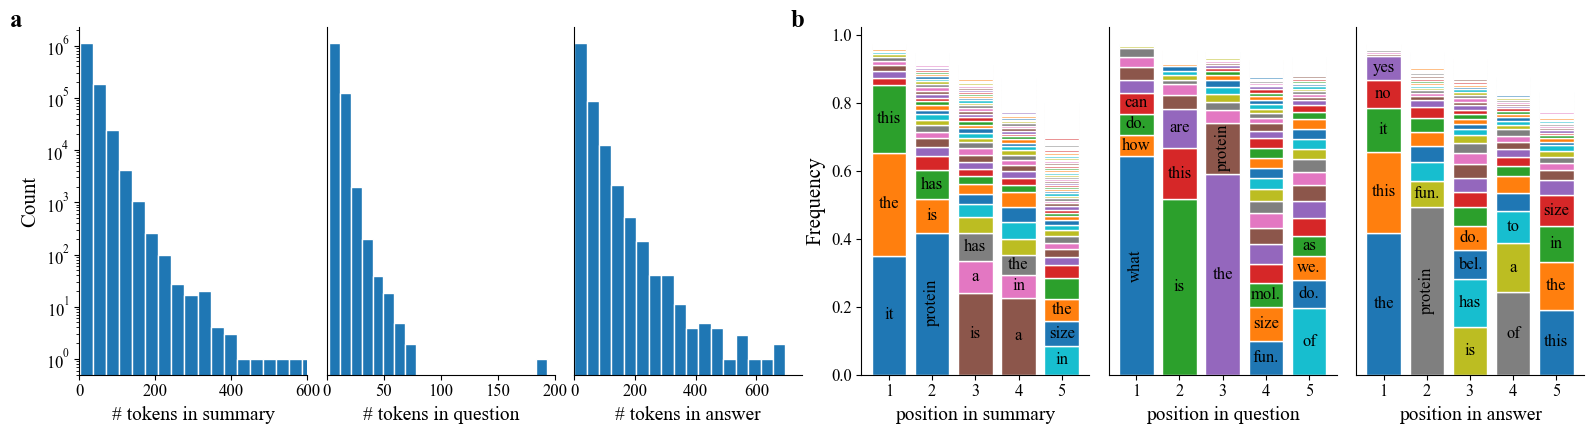

In [11]:
# with open("word_freqs.pkl", "rb") as f:
#     bars = pickle.load(f)
# with open("token_counts.pkl", "rb") as f:
#     counts = pickle.load(f)
six_plots([at, bt, ct], [{k: dict(v) for k, v in i.items()} for i in _bars], 'test.png')

In [12]:
print(sorted(at)[len(at)//2]), print(sorted(bt)[len(bt)//2]), print(sorted(ct)[len(ct)//2])

23
8
15


(None, None, None)